# Demo Artificial Intelligence Programming

In [1]:
import Modules.Simworld as Simworld
from Modules.AI_classes import Actor, Critic,Critic_NN
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display
import time
import pickle

## Pivotal parameters

In [20]:
##HYPER PARAMETERS######

#ACTOR PARAMETERS
LEARNING_RATE_ACTOR = 0.9
ELIGIBILITY_DECAY_ACTOR = 0.8
DISCOUNT_FACTOR_ACTOR = 0.99
EPSILON_DECAY_DEGREE = 1 #Polynomic decay of epsilon 1: linear, 2: quadratic etc.
STRATEGY = "EPSILON-GREEDY"

#CRITIC PARAMETERS
NEURALNET = True
LEARNING_RATE_CRITIC = 0.5
ELIGIBILITY_DECAY_CRITIC = 0.8
DISCOUNT_FACTOR_CRITIC = 0.97
HIDDEN_LAYERS = (4,5)

#GAME PARAMETERS
EPISODES = 500
OPEN_CELLS = [(1,2)]
BOARD_TYPE = "diamond" #"diamond"
BOARD_SIZE = 4

#VISUALIZATION PARAMETERS
DISPLAY_DELAY = 1
SHOW = True
SAVE_ACTOR_AND_CRITIC = True

## Initialize environment, critic and 

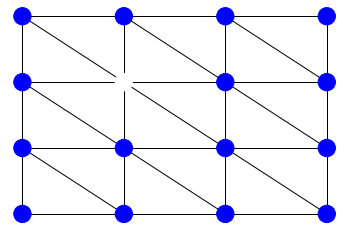

In [14]:
environment = Simworld.Peg_Solitaire(BOARD_TYPE,BOARD_SIZE,OPEN_CELLS)
display.display(Simworld.visualize_state(environment))

In [15]:
actor = Actor(LEARNING_RATE_ACTOR,ELIGIBILITY_DECAY_ACTOR,DISCOUNT_FACTOR_ACTOR,EPSILON_DECAY_DEGREE,STRATEGY,EPISODES)
if NEURALNET:
    critic = Critic_NN(LEARNING_RATE_CRITIC,ELIGIBILITY_DECAY_CRITIC,DISCOUNT_FACTOR_CRITIC,environment,HIDDEN_LAYERS)
else:
    critic = Critic(LEARNING_RATE_CRITIC,ELIGIBILITY_DECAY_CRITIC,DISCOUNT_FACTOR_CRITIC)


# Training actor and critic

In [16]:
bricks = []
for episode in tqdm(range(EPISODES)):
    environment.reset()
    is_final = environment.is_final_state()
    state = environment.get_state()
    episode_SAP = set()
    state_td_map = {}
    actor.reset_eligibility()
    critic.reset_eligibility()
    while not is_final:
        action_list = environment.legal_actions()
        actor.add_new_SAP(state,action_list)
        action = actor.get_action(state,episode)
        next_state, reward, is_final = environment.step(action)
        
        episode_SAP.add((state,action))
        actor.eligibility[(state,action)]=1
        if not NEURALNET:
            critic.eligibility[state] = 1
        td_error = critic.calculate_td_error(reward,next_state,state)
        
        #Store temporal difference for training after episode
        state_td_map[state] = td_error
        for state,action in episode_SAP:
            actor.update_policy(state,action,td_error)
            actor.update_eligibility(state,action)
            if not NEURALNET:
                critic.update_value_function(state,td_error)
                critic.update_eligibility(state)
        if NEURALNET:
            critic.update_value_function(state, td_error)
        state = next_state
            
            
    bricks.append(reward if reward>0 else -reward)

df = pd.DataFrame({'bricks':bricks})  

  0%|          | 0/500 [00:00<?, ?it/s]/Users/Sigurd/AI programming/KI_1/Modules/AI_classes.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gradients = np.array([gradient.numpy() for gradient in gradients])
/Users/Sigurd/AI programming/KI_1/Modules/AI_classes.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  weights = np.array(self.model.get_weights())
100%|██████████| 500/500 [39:28<00:00,  4.74s/it]  


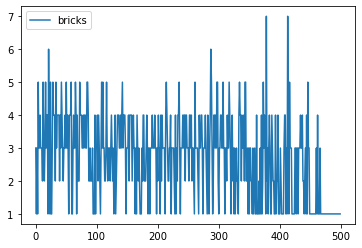

In [17]:
df = pd.DataFrame({'bricks':bricks})
df.plot()
plt.show()

## Visualize optimal policy

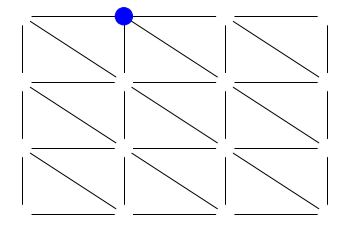

In [18]:
if SHOW:
    actor.strategy = "GREEDY"
    environment.reset()
    is_final = environment.is_final_state()
    state = environment.get_state()
    while not is_final:
        frame = Simworld.visualize_state(environment)
        display.clear_output(wait=True)
        display.display(frame)
        time.sleep(DISPLAY_DELAY)

        #Add SAP in case there are new states
        action_list = environment.legal_actions()
        actor.add_new_SAP(state,action_list)

        action = actor.get_action(state,episode)
        next_state, reward, is_final = environment.step(action)
        state = next_state

    display.clear_output(wait=True)
    frame = Simworld.visualize_state(environment)
    display.display(frame)

In [31]:
if SAVE_ACTOR_AND_CRITIC:
    actor_and_critic = {"actor":copy.deepcopy(actor), "critic":copy.deepcopy(critic), "environment":copy.deepcopy(environment),"progression": df}
    #Save actor with parameters
    name = input("File name: ")
    pickle.dump(actor_and_critic, open(f"{name}.pkl",'wb'))

TypeError: can't pickle _thread._local objects

In [25]:
critic.value_function.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 25        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [28]:
import copy

In [30]:
copy.deepcopy(actor)